# Initialize Notebook

In [1]:
# Import dependencies and set basic variables
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable #from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
import seaborn as sns
import networkx as nx
from connectivity.parCorrInvCov import parCorrInvCov
#from connectivity.multipleRegression import multipleRegression
#from connectivity.graphicalLassoCV import graphicalLassoCV
from metrics.matrixSimilarity import matrixSimilarity
from plotting.scaledColorMap import scaledColorMap
import math
import time
import sys

# Project directories
dataDir = '/projects/f_mc1689_1/ReliableFC/data'
scriptsDir = '/projects/f_mc1689_1/ReliableFC/docs/scripts'
figDir = '/projects/f_mc1689_1/ReliableFC/docs/figures'

# For figures
plt.rcParams.update({'font.size': 7})
from pathlib import Path
import matplotlib as mpl
from matplotlib import font_manager as fm
font_file = Path(mpl.get_data_path(),f'{scriptsDir}/plotting/arial/arial.ttf')
fm.fontManager.addfont(font_file)
font_file = Path(mpl.get_data_path(),f'{scriptsDir}/plotting/arial/arialbd.ttf')
fm.fontManager.addfont(font_file)
plt.rcParams.update({'font.family': 'arial'})

In [2]:
def formatTStat(t):
    if abs(t)>=100: tStr = f'{t:03.0f}'
    elif abs(t)>=10: tStr = f'{t:02.1f}'
    elif abs(t)>=1: tStr = f'{t:01.2f}'
    else: tStr = f'{t:00.3f}'
    return tStr

def formatPVal(p,noSpace=False):
    if p<.00001: 
        if noSpace: pStr = '<.00001'
        else: pStr = '< .00001'
    else:
        if p<.0001: pStr = f'{p:.5f}'
        elif p<.001: pStr = f'{p:.4f}'
        else: pStr = f'{p:.3f}'
        if noSpace: pStr = f'={pStr[1:]}'
        else: pStr = f'= {pStr[1:]}'
    return pStr

def correlatedCorrelations(r_x1y,r_x2y,r_x1x2,N):
    z_x1y = np.arctanh(r_x1y)
    z_x2y = np.arctanh(r_x2y)
    #z_x1x2 = np.arctanh(r_x1x2)
    
    meanr2_x = (r_x1y**2 + r_x2y**2)/2
    f = (1-r_x1x2)/(2*(1-meanr2_x))
    if f > 1:
        f = 1
    h = (1-f*meanr2_x)/(1-meanr2_x)
    
    Z = (z_x1y-z_x2y)*((N-3)/(2*(1-r_x1x2)*h))**.5
    pval = stats.norm.sf(abs(Z))*2 #(2-tailed)
    
    return Z,pval
    

In [3]:
methodsList = ['pairwiseCorr','partialCorr','graphicalLasso','graphicalRidge','pcRegression']

paramsFull = {}
paramsFull['pairwiseCorr'] = None
paramsFull['partialCorr'] = None
paramsFull['graphicalLasso'] = np.round(np.hstack([np.arange(0,.01,.002),np.arange(.01,.41,.01)]),3)
paramsFull['graphicalRidge'] = np.round(np.hstack([np.arange(0,.1,.02),np.arange(.1,4.1,.1)]),3)
paramsFull['pcRegression'] = np.round(np.hstack([np.arange(5,10,1),np.arange(10,101,5)]),3)
paramsFull['pcRegression'][-1] = 99

# Simulation Modes/Settings

In [4]:
nNodes = 100  
nModules = 5

# Main Analysis
k = 4
boldConv = False
noiseAndTRs = False
nSims = 50
nSes = 100

# Supplement: Less Sparse
#k = 8
#boldConv = False
#noiseAndTRs = False
#nSims = 25
#nSes = 100

# Supplement: HRF Convolution
#k = 4
#boldConv = True
#noiseAndTRs = False
#nSims = 25
#nSes = 100

# Noise and TRs Analysis
#k = 4
#boldConv = False
#noiseAndTRs = True
#nSims = 50
#nSes = 1

path = f'{dataDir}/simulations/BANet_k-{k}_nModules-{nModules}'

if boldConv:
    path = f'{path}_boldConv'
    
if noiseAndTRs:
    path = f'{path}/noiseAndTRs'
    nTRsList = np.array([50,100,200,300,400,500,1000,10000],dtype=int)
    noiseLevelsList = [.25,.5,1]
else:
    nTRs = 250 
    noiseLevel = .5
    nTRsList = np.array([250],dtype=int)
    noiseLevelsList = [.5]


# Generate Networks and Timeseries

In [ ]:
# Generate edges in an undirected Barabasi-Albert network (base function)
def BANet(n,k):
# n- number of nodes
# k- coefficient of attachment (number of edges added with each new node)
    mat = np.zeros((n,n))
    kInt = math.floor(k)
    kRem = k-kInt
    
    # Begin with k nodes, all fully connected
    for i in range(kInt):
        mat[i,i+1:kInt] = 1
        mat[i+1:kInt,i] = 1
       
    # Add one node at a time (and its attachments) until there are n nodes total
    for i in range(kInt,n):
        # Add attachments preferentially to nodes that already have many edges
        rand = np.random.rand(n,n) * mat # Assign random values to existing edges (nodes with more edges have greater probability of highest value)
        # Deal with decimal portion of k 
        extra = (kRem*(i+1)//1)-(kRem*(i)//1)
        while np.sum(mat[i,:])<np.amin([(kInt+extra),i]):
            #print(i,np.sum(mat[i,:]),kInt+extra)
            idx = np.argwhere(rand == np.amax(rand))[0] # Find location of the (next) largest random value
            mat[i,idx[0]] = 1 # Assign an edge between new node and node whose row contained highest value
            mat[idx[0],i] = 1 # (Nodes with more edges have a higher probability of gaining more)
            rand[idx[0],idx[1]] = 0 # Set that value to zero in random matrix
            
    return mat

# Directed scale-free random network (Barabasi-Albert)
def generateWeights_BANet(nNodes=nNodes,nModules=nModules,k=4,ratioOutsideMods=.25,weightsSD=1,weightsMeanIn=1,weightsMeanOut=.5,inhibMods=[]):
# nNodes- number of nodes in simulated network
# nModules- number of equal-size modules in network
# k- coefficient of attachment (number of edges added with each new node)
# ratioOutsideMods- proportion of extra-modular edges as a fraction of intra-modular edges
# weightsSD- standard deviation of edge weights
# weightsMeanIn- mean within-module edge weight
# weightsMeanOut- mean outside-module edge weight
# inhibMods- list of module indices for inhibitory modules

    # Generate edge backbone with modular structure and within-module mask
    edges = np.zeros((nNodes,nNodes)) #(edge=1, non-edge=0)
    modMat = np.zeros((nNodes,nNodes)) + 2 #(diagonal=0, within same module=1, outside modules=2)
    nodesPerMod = nNodes//nModules
    for m in range(nModules):
        modMat[m*nodesPerMod:(m+1)*nodesPerMod,m*nodesPerMod:(m+1)*nodesPerMod] = 1
        #Generate smaller Barabasi-Albert networks for within-module edges
        edges[m*nodesPerMod:(m+1)*nodesPerMod,m*nodesPerMod:(m+1)*nodesPerMod] = BANet(nodesPerMod,k)
    np.fill_diagonal(modMat,0)
    
    # Generate inhibitory module mask (mean edge weights between inhibitory-noninhibitory modules multiplied by -1)
    inhib = np.ones((nNodes,1))
    for im in inhibMods:
        inhib[im*nodesPerMod:(im+1)*nodesPerMod] = -1
    inhibition = np.matmul(inhib,inhib.T)
        
    # Add extra-modular edges, preferentially adding to high-degree nodes
    edgesWithinMods = np.sum(edges)
    densityWithinMods = edgesWithinMods/np.sum(modMat==1)
    while (np.sum(edges[modMat==2])/np.sum(modMat==2)) < (densityWithinMods*ratioOutsideMods): # Add edges until desired density
        rand = edges * np.random.rand(nNodes,nNodes) # Assign random values to existing edges
        idx1 = np.argwhere(rand == np.amax(rand))[0] # Locate largest value  
        rand[idx1[0],idx1[1]] = 0
        rand[modMat[idx1[0],:]==1,:] = 0
        idx2 = np.argwhere(rand == np.amax(rand))[0] # Locate next largest value
        rand[idx2[0],idx2[1]] = 0
        # If the two nodes whose rows contained highest values are in different modules, then add edge between them
        if modMat[idx1[0],idx2[0]]==2:
            edges[idx1[0],idx2[0]] = 1
            edges[idx2[0],idx1[0]] = 1
    
    # Determine nonzero edge weights    
    W = np.random.randn(nNodes,nNodes) * weightsSD
    Wmean = np.zeros((W.shape))
    Wmean[modMat==2] = weightsMeanOut
    Wmean[modMat==1] = weightsMeanIn
    Wmean = Wmean*inhibition
    W = W + Wmean
    W = edges*W # Assign weights to nonzero edges 
    W = (W/(np.sum(W)/nNodes)) # Normalize weights by mean node weighted degree
    np.fill_diagonal(W,0)
    
    # Export symmetrical version as well
    Wsym = (W+W.T)/2
    
    return W,Wsym


In [ ]:
# Simulate node timeseries from a directed network using linear models
def generateTimeseries(W,nTRs,E=None):
# W- directed connectivity matrix
# nTRs- number of timepoints to generate

    # Timeseries are modeled using the equation, X = WX + E, where X is vector of nodes' timeseries, W is 
    # connectivity matrix, and E is vector of nodes' independent noise terms. The equation can be expressed
    # as X = (I − W)^(−1)E to compute the timeseries (X).
    # See Sanchez-Romero and Cole, 2020
    nNodes = W.shape[0]
    I = np.eye(nNodes)
    if E is None:
        E = np.random.randn(nNodes,nTRs)
    X = np.matmul(np.linalg.inv(I - W), E)
    
    return X

def convolveHRF(neural,hrf):
# neural- neural activity timeseries [node x timepoints]
# hrf- HRF template
    nNodes = neural.shape[0]
    bold = np.zeros((neural.shape))
    for n in range(nNodes):
        bold[n,:] = np.convolve(neural[n,:],hrf)[:neural.shape[1]]
    return bold

# Generate random neural data timeseries from Poisson distribution
def poissonSignal(nNodes,TRNeural,nTRsNeural,lamSwitchDown=2.5,lamSwitchUp=10,noiseSD=.05):   
# nNodes- number of nodes
# TRNeural- sampling rate (s)
# nTRsNeural- number of samples to generate
# lamSwitchDown- mean time (s) in "up" state
# lamSwitchUp- mean time (s) in "down" state
# noiseSD- standard deviation of added Gaussian noise (relative to up-down amplitude)
    
    # Based on Smith et al., 2011
    buffer = int(100//TRNeural)
    E = np.zeros((nNodes,nTRsNeural+buffer))
    for n in range(nNodes):
        tSwitchDown = np.random.rand(1)*lamSwitchUp
        tSwitchDownIdx = int(tSwitchDown//TRNeural)
        while True:
            tSwitchUp = tSwitchDown + np.random.poisson(lam=lamSwitchUp)
            tSwitchUpIdx = int(tSwitchUp//TRNeural)
            tSwitchDown = tSwitchUp + np.random.poisson(lam=lamSwitchDown)
            tSwitchDownIdx = int(tSwitchDown//TRNeural)
            if tSwitchDownIdx >= (nTRsNeural+buffer):
                if tSwitchUpIdx >= (nTRsNeural+buffer):
                    break
                else:
                    E[n,tSwitchUpIdx:] = 1
                    break
            E[n,tSwitchUpIdx:tSwitchDownIdx] = 1
    E = E + np.random.randn(E.shape[0],E.shape[1])*noiseSD
    E = E[:,buffer:]
    return E


In [ ]:
from nipy.modalities.fmri.hemodynamic_models import compute_regressor

if boldConv:
    TR = 2
    TRNeural = .05
    eventInfo = np.array((0,TRNeural,1)).reshape(3,1)
    hrfTime = 30 # seconds
    hrf = compute_regressor(eventInfo,'spm',np.arange(hrfTime/TRNeural)*TRNeural)[0].squeeze()
    
if k==4:
    Wscale = .6
if k==8:
    Wscale = .65
    
if not os.path.exists(path):
    os.makedirs(path)
    
nTRsMax = int(nTRsList[nTRsList==np.amax(nTRsList)])
    
for sim in range(nSims):
    print(f'Sim-{sim}')
    h5filename = f'{path}/sim-{sim}.h5'
    with h5py.File(h5filename,'a') as h5file:
        try:
            W = h5file['W'][:]
            Wsym = h5file['Wsym'][:]
            print(f'Network {sim} exists')
        except:
            W,Wsym = generateWeights_BANet(nNodes=nNodes,nModules=nModules,k=k,weightsSD=1,weightsMeanIn=1,weightsMeanOut=.5,ratioOutsideMods=(1/(nModules-1))/4,inhibMods=[4])#[6,7])
            W = W * Wscale
            Wsym = Wsym * Wscale
            h5file.create_dataset('W',data=W)
            h5file.create_dataset('Wsym',data=Wsym)
            print(f'Creating network {sim}')
    
    for ses in range(nSes):
        try:
            with h5py.File(h5filename,'r') as h5file:
                signal = h5file[f'ses-{ses}/signal'][:]
                noise = h5file[f'ses-{ses}/noise'][:]
                print(f'\tSession {ses} exists')
        except:
            if boldConv:
                totalTime = nTRsMax*TR
                nTRsNeural = int(totalTime/TRNeural)
                neuralTimepoints = np.round(np.arange(-hrfTime,totalTime,TRNeural),6)
                boldDownsample = (neuralTimepoints>=0)&((np.round(neuralTimepoints/TR,6)%1)==0)
                E = poissonSignal(nNodes,TRNeural,nTRsNeural+len(hrf))
                neural = generateTimeseries(W,nTRsNeural+len(hrf),E=E)
                signal = convolveHRF(neural,hrf)[:,boldDownsample]
            else:
                E = np.random.randn(nNodes,nTRsMax)
                signal = generateTimeseries(W,nTRsMax,E=E)
            noise = np.random.randn(nNodes,nTRsMax)
            with h5py.File(h5filename,'a') as h5file:
                h5file.create_dataset(f'ses-{ses}/signal',data=signal)
                h5file.create_dataset(f'ses-{ses}/noise',data=noise)
                print(f'\tCreating session {ses}')
                   
        for nTRs_ in nTRsList:
            for noiseLevel_ in noiseLevelsList:
                with h5py.File(h5filename,'a') as h5file:
                    try:
                        data = h5file[f'ses-{ses}/noise-{noiseLevel_}/nTRs-{nTRs_}/data'][:]
                        print(f'\t\t{nTRs_} TRs, {noiseLevel_} noise exists')
                    except:
                        data = stats.zscore(signal[:,0:nTRs_],axis=1) + stats.zscore(noise[:,0:nTRs_],axis=1)*noiseLevel_
                        h5file.create_dataset(f'ses-{ses}/noise-{noiseLevel_}/nTRs-{nTRs_}/data',data=data)
                        print(f'\t\tCreating {nTRs_} TRs, {noiseLevel_} noise')
    

# Calculate FC

In [ ]:
method = 'graphicalLasso'
#method = 'graphicalRidge'
#method = 'pcRegression'
#method = 'partialCorr'
#method = 'pairwiseCorr'

for sim in range(nSims):
    os.system(f'{scriptsDir}/connectivity/simFC_batch.sh {sim} {method} [0] [.25,.5,1] [50,100,200,300,400,500,1000,10000]')
    #os.system(f'{scriptsDir}/connectivity/simFC_batch.sh {sim} {method} [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]')
    

In [5]:
for method in ['graphicalLasso','graphicalRidge','pcRegression']:
    print(method)
    for t,nTRs_ in enumerate(nTRsList):
        for no,noiseLevel_ in enumerate(noiseLevelsList):
            bestParams = np.full((nSims,nSes),np.nan) #,len(ntrsList),len(noiseLevelsList)
            for sim in range(nSims):
                for ses in range(nSes):
                    outDir = f'{path}/{method}/{sim}_{ses}_noiseLevel-{noiseLevel_}_nTRs-{nTRs_}'
                    bestParams[sim,ses] = np.load(f'{outDir}/bestParam.npy')
                    
            print(nTRs_,noiseLevel_)
            print(np.amin(bestParams),np.amax(bestParams))
            print(np.mean(bestParams),np.std(bestParams))
            print()
            #plt.figure()
            #plt.hist(bestParams.flatten())
            #plt.title(f'{method}, nTRs-{ntrs}, noise-{noiseLevel}')
            

graphicalLasso
250 0.5
0.09 0.13
0.11170799999999999 0.006238808860672043

graphicalRidge
250 0.5
1.0 1.7
1.3072 0.1063022107013772

pcRegression
250 0.5
10.0 25.0
11.189 2.445665349143255



## Aggregate FC matrices

In [ ]:
# Save all ground-truth networks into one array and file
W = np.full((nNodes,nNodes,nSims),np.nan)
Wsym = np.full((nNodes,nNodes,nSims),np.nan)

for sim in range(nSims):
    simFile = f'{path}/sim-{sim}.h5'
    with h5py.File(simFile,'r') as h5file:
        W[:,:,sim] = h5file['W'][:]
        Wsym[:,:,sim] = h5file['Wsym'][:]
        
gtFile = f'{path}/groundTruth.h5'
with h5py.File(gtFile,'a') as h5file:
    try:
        h5file.create_dataset('W',data=W)
        h5file.create_dataset('Wsym',data=Wsym)
    except:
        del h5file['W'], h5file['Wsym']
        h5file.create_dataset('W',data=W)
        h5file.create_dataset('Wsym',data=Wsym)
 

In [ ]:
# Aggregate FC matrices from regularized methods
# Save an .h5 file for each method with all simulations' data 
for method in ['pairwiseCorr','partialCorr','graphicalLasso','graphicalRidge','pcRegression']:
    print(method)
    connFileFinal = f'{path}/{method}.h5'
    with h5py.File(connFileFinal,'a') as h5File:
        for t,ntrs in enumerate(ntrsList):
            for no,noiseLevel in enumerate(noiseLevelsList):
                for ses in range(nSes):
                    print(ses, ntrs, noiseLevel)
                    connOpt = np.full((nNodes,nNodes,nSims),np.nan)
                    paramsOpt = np.full((nSims),np.nan)
                    if (paramsFull[method] is None):
                        for sim in range(nSims):
                            connFileOpt = f'{path}/{method}/{sim}_{ses}_noiseLevel-{noiseLevel}_nTRs-{ntrs}/{method}.npy'
                            connOpt[:,:,sim] = np.load(connFileOpt)
                            np.fill_diagonal(connOpt[:,:,sim],0)
                            connOpt[:,:,sim] = (connOpt[:,:,sim]+connOpt[:,:,sim].T)/2
                        try:
                            h5File.create_dataset(f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/FC',data=connOpt)
                        except:
                            del h5File[f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/FC']
                            h5File.create_dataset(f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/FC',data=connOpt)
            
                    else:
                        for sim in range(nSims):
                            connFileOpt = f'{path}/{method}/{sim}_{ses}_noiseLevel-{noiseLevel}_nTRs-{ntrs}/{method}_opt-R2.npy'
                            connOpt[:,:,sim] = np.load(connFileOpt)
                            paramFileOpt = f'{path}/{method}/{sim}_{ses}_noiseLevel-{noiseLevel}_nTRs-{ntrs}/bestParam.npy'
                            paramsOpt[sim] = np.load(paramFileOpt)
                            np.fill_diagonal(connOpt[:,:,sim],0)
                            connOpt[:,:,sim] = (connOpt[:,:,sim]+connOpt[:,:,sim].T)/2
                        try:
                            h5File.create_dataset(f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/FC',data=connOpt)
                        except:
                            del h5File[f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/FC']
                            h5File.create_dataset(f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/FC',data=connOpt)
                        try:
                            h5File.create_dataset(f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/bestParams',data=paramsOpt)
                        except:
                            del h5File[f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/bestParams']
                            h5File.create_dataset(f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/bestParams',data=paramsOpt)
                    
                        if noiseAndTRs:
                            continue
                        for param in paramsFull[method]:
                            connParam = np.full((nNodes,nNodes,nSims),np.nan)
                            for sim in range(nSims):
                                connFileParam = f'{path}/{method}/{sim}_{ses}_noiseLevel-{noiseLevel}_nTRs-{ntrs}/FC_param-{param}.npy'
                                connParam[:,:,sim] = np.load(connFileParam)
                                np.fill_diagonal(connParam[:,:,sim],0)
                                connParam[:,:,sim] = (connParam[:,:,sim]+connParam[:,:,sim].T)/2
                            try:
                                h5File.create_dataset(f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/param-{param}/FC',data=connParam)
                            except:
                                del h5File[f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/param-{param}/FC']
                                h5File.create_dataset(f'ses-{ses}/noiseLevel-{noiseLevel}/nTRs-{ntrs}/param-{param}/FC',data=connParam)
        

# Main (and Supplemental) Analyses

## Load data

In [6]:
gtFile = f'{path}/groundTruth.h5'
with h5py.File(gtFile,'r') as h5file:
    W = h5file['W'][:]
    Wsym = h5file['Wsym'][:]
    
FC = {}
FCByParam = {}
for method in methodsList:
    print(method)
    connFileFinal = f'{path}/{method}.h5'
    FC[method] = np.full((nNodes,nNodes,nSims,nSes),np.nan)
    if not (paramsFull[method] is None):
        FCByParam[method] = np.full((nNodes,nNodes,nSims,nSes,len(paramsFull[method])),np.nan)
    with h5py.File(connFileFinal,'r') as h5File:
        for ses in range(nSes):
            #print(ses)
            FC[method][:,:,:,ses] = h5File[f'ses-{ses}/FC'][:]
            if not (paramsFull[method] is None):
                for p,param in enumerate(paramsFull[method]):
                    FCByParam[method][:,:,:,ses,p] = h5File[f'ses-{ses}/param-{param}/FC'][:]
            

pairwiseCorr
partialCorr
graphicalLasso
graphicalRidge
pcRegression


## Visualize exemplar matrices

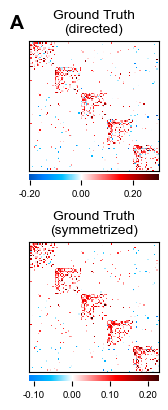

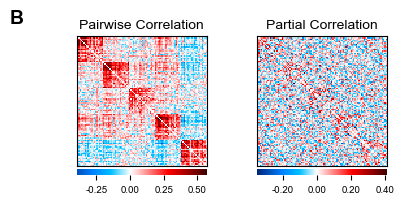

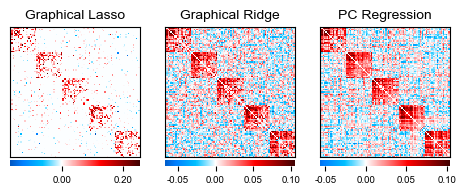

In [7]:
plt.rcParams.update({'font.size':7})

methodsList_fig = {0:['Ground Truth\n(directed)','Ground Truth\n(symmetrized)'], 1:['pairwiseCorr','partialCorr'], 2:['graphicalLasso','graphicalRidge','pcRegression']}
methodsPrintList = {0:['Ground Truth\n(directed)','Ground Truth\n(symmetrized)'],1:['Pairwise Correlation','Partial Correlation'], 2:['Graphical Lasso','Graphical Ridge','PC Regression']}

if (k==4) and (boldConv==False):
    sim = 13
elif (k==8) and (boldConv==False):
    sim = 4
elif (k==4) and (boldConv==True):
    sim = 5
ses = 0

for row in [0,1,2]:
    if row==0:
        fig,axs = plt.subplots(2,1,figsize=(6.5,4),sharex='col',sharey='row',gridspec_kw={'hspace':.446})
        fig.subplots_adjust(left=.033,right=0.233,top=.9,bottom=.05)
    elif row==1:
        fig,axs = plt.subplots(1,2,figsize=(6.5,4),sharex='col',sharey='row',gridspec_kw={'wspace':.385})
        fig.subplots_adjust(left=.410,right=0.887,top=.9,bottom=.553)
    elif row==2:
        fig,axs = plt.subplots(1,3,figsize=(6.5,4),sharex='col',sharey='row',gridspec_kw={'wspace':.192})
        fig.subplots_adjust(left=.310,right=0.987,top=.398,bottom=0.05)

    for m,method in enumerate(methodsList_fig[row]):
        if row==0:
            if m==0: conn = W[:,:,sim]
            if m==1: conn = Wsym[:,:,sim]
        else:
            conn = FC[method][:,:,sim,ses]

        vMax = np.amax(conn)
        vMin = np.amin(conn)
        cdict = scaledColorMap(vMin,vMax)
        cmp = colors.LinearSegmentedColormap('scaledBlueRed',cdict)
        
        im = axs[m].imshow(conn,cmap=cmp,vmin=vMin,vmax=vMax,interpolation='nearest')
        
        divider = make_axes_locatable(axs[m])
        cax = divider.append_axes("bottom", size="5%", pad=0.025)
        if row==0:
            cb = plt.colorbar(im,cax=cax,format="%0.2f",orientation='horizontal')#,ticks=[0,.1,.2,.3])
        else:
            cb = plt.colorbar(im,cax=cax,format="%0.2f",orientation='horizontal')#,ticks=vTicks)#[-vMaxTick,0,vMaxTick])
        cb.outline.set_visible(False)
        
        axs[m].set_xticks([])
        axs[m].set_yticks([])
        axs[m].set_title(methodsPrintList[row][m],size=10)
        
    if row==0:
        axs[0].text(-15,axs[0].get_ylim()[1]-10,'A',fontsize=14,ha='left',weight='bold')
    if row==1:
        axs[0].text(-52,axs[0].get_ylim()[1]-10,'B',fontsize=14,ha='left',weight='bold')  
    
    if (k==4) and (boldConv==False):
        figFilename = f'{figDir}/fig5-{row}.pdf'
    elif (k==8) and (boldConv==False):
        figFilename = f'{figDir}/figS-{row}_lessSparseSims_fcMats.pdf'
    elif (k==4) and (boldConv==True):
        figFilename = f'{figDir}/figS-{row}_boldConvSims_fcMats.pdf'

    fig.savefig(figFilename,dpi=600,transparent=True)


## Calculate Metrics

In [8]:
from metrics.matrixSimilarity import matrixSimilarity

# Calculate between-ses similarity and individual and ses-averaged ground truth similarity
sesSimDF = pd.DataFrame(data={'Method':[],'Data':[]})
sesSimByParam = {}
gtSimDF = pd.DataFrame(data={'Method':[],'Data':[]})
gtSimByParam = {}
gtSimAvgDF = pd.DataFrame(data={'Method':[],'Data':[]})
gtSimAvgByParam = {}
for m,method in enumerate(methodsList):
    #print(method)
    # Results from FC matrices with optimal hyperparam (figure left panel box plots)
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    tmpDF['Data'] = matrixSimilarity(FC[method][:,:,:,0],FC[method][:,:,:,1])
    tmpDF['Method'] = method
    sesSimDF = pd.concat([sesSimDF,tmpDF])
    
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    tmpDF['Data'] = matrixSimilarity(FC[method][:,:,:,0],Wsym)
    tmpDF['Method'] = method
    gtSimDF = pd.concat([gtSimDF,tmpDF])
    
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    tmpDF['Data'] = matrixSimilarity(np.mean(FC[method][:,:,:,:],axis=3),Wsym)
    tmpDF['Method'] = method
    gtSimAvgDF = pd.concat([gtSimAvgDF,tmpDF])
    
    # Results from FC matrices across range of hyperparam values (figure right panels; regularized methods only)
    if not (paramsFull[method] is None):
        sesSimByParam[method] = np.full((nSims,len(paramsFull[method])),np.nan)
        gtSimByParam[method] = np.full((nSims,len(paramsFull[method])),np.nan)
        gtSimAvgByParam[method] = np.full((nSims,len(paramsFull[method])),np.nan)
        for p,param in enumerate(paramsFull[method]):
            sesSimByParam[method][:,p] = matrixSimilarity(FCByParam[method][:,:,:,0,p],FCByParam[method][:,:,:,1,p])
            gtSimByParam[method][:,p] = matrixSimilarity(FCByParam[method][:,:,:,0,p],Wsym)
            gtSimAvgByParam[method][:,p] = matrixSimilarity(np.mean(FCByParam[method][:,:,:,:,p],axis=3),Wsym)

    print(f'{method}')
    print(f'\tbetween-session similarity: mean r = {np.mean(sesSimDF.loc[sesSimDF["Method"]==method,"Data"]):.3f}, SD = {np.std(sesSimDF.loc[sesSimDF["Method"]==method,"Data"]):.3f}')
    print(f'\tgroup-averaged ground truth similarity: mean r = {np.mean(gtSimAvgDF.loc[gtSimAvgDF["Method"]==method,"Data"]):.3f}, SD = {np.std(gtSimAvgDF.loc[gtSimAvgDF["Method"]==method,"Data"]):.3f}')
    print(f'\tindividual ground truth similarity: mean r = {np.mean(gtSimDF.loc[gtSimDF["Method"]==method,"Data"]):.3f}, SD = {np.std(gtSimDF.loc[gtSimDF["Method"]==method,"Data"]):.3f}')
    print()


pairwiseCorr
	between-session similarity: mean r = 0.786, SD = 0.048
	group-averaged ground truth similarity: mean r = 0.628, SD = 0.048
	individual ground truth similarity: mean r = 0.556, SD = 0.034

partialCorr
	between-session similarity: mean r = 0.158, SD = 0.015
	group-averaged ground truth similarity: mean r = 0.952, SD = 0.005
	individual ground truth similarity: mean r = 0.384, SD = 0.013

graphicalLasso
	between-session similarity: mean r = 0.735, SD = 0.018
	group-averaged ground truth similarity: mean r = 0.944, SD = 0.005
	individual ground truth similarity: mean r = 0.808, SD = 0.014

graphicalRidge
	between-session similarity: mean r = 0.581, SD = 0.024
	group-averaged ground truth similarity: mean r = 0.794, SD = 0.015
	individual ground truth similarity: mean r = 0.607, SD = 0.012

pcRegression
	between-session similarity: mean r = 0.601, SD = 0.053
	group-averaged ground truth similarity: mean r = 0.637, SD = 0.013
	individual ground truth similarity: mean r = 0.495,

## Make Table

In [9]:
methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']
colNames = [(' ','row'),(' ','Methods'),(' ',"Between-Session Similarity (Pearson's r)"),("Ground Truth Similarity (Pearson's r)","Network-Averaged"),("Ground Truth Similarity (Pearson's r)","Individual")]

if (k==4) and (boldConv==False):
    tableFilename = f'{figDir}/table2.tsv'
elif (k==8) and (boldConv==False):
    tableFilename = f'{figDir}/tableS_lessSparseSims.tsv'
elif (k==4) and (boldConv==True):
    tableFilename = f'{figDir}/tableS_boldConvSims.tsv'
    
if os.path.exists(tableFilename):
    tableDF = pd.read_csv(tableFilename,sep='\t',index_col=0,header=[0,1])
else:
    tableDF = pd.DataFrame(columns=pd.MultiIndex.from_tuples(colNames, names=["line1", "line2"]))

i = 1
for m1,method1 in enumerate(methodsList):
    for m2,method2 in enumerate(methodsList):
        if m2 <= m1:
            continue
        tableDF.loc[i,(' ','row')] = i
        tableDF.loc[i,(' ','Methods')] = f'{methodsPrintedLabels[m1]} vs. {methodsPrintedLabels[m2]}'
        
        diff = np.mean(sesSimDF.loc[sesSimDF['Method']==method1,'Data']-sesSimDF.loc[sesSimDF['Method']==method2,'Data'])
        [t,p] = stats.ttest_rel(sesSimDF.loc[sesSimDF['Method']==method1,'Data'],sesSimDF.loc[sesSimDF['Method']==method2,'Data'])
        tableStr = f'mean ∆r = {diff:.3f}, T({nSims-1}) = {formatTStat(t)}, p {formatPVal(p)}'
        tableDF.loc[i,(' ',"Between-Session Similarity (Pearson's r)")] = tableStr
        
        diff = np.mean(gtSimAvgDF.loc[gtSimAvgDF['Method']==method1,'Data']-gtSimAvgDF.loc[gtSimAvgDF['Method']==method2,'Data'])
        [t,p] = stats.ttest_rel(gtSimAvgDF.loc[gtSimAvgDF['Method']==method1,'Data'],gtSimAvgDF.loc[gtSimAvgDF['Method']==method2,'Data'])
        tableStr = f'mean ∆r = {diff:.3f}, T({nSims-1}) = {formatTStat(t)}, p {formatPVal(p)}'
        tableDF.loc[i,("Ground Truth Similarity (Pearson's r)","Network-Averaged")] = tableStr
        
        diff = np.mean(gtSimDF.loc[gtSimDF['Method']==method1,'Data']-gtSimDF.loc[gtSimDF['Method']==method2,'Data'])
        [t,p] = stats.ttest_rel(gtSimDF.loc[gtSimDF['Method']==method1,'Data'],gtSimDF.loc[gtSimDF['Method']==method2,'Data'])
        tableStr = f'mean ∆r = {diff:.3f}, T({nSims-1}) = {formatTStat(t)}, p {formatPVal(p)}'
        tableDF.loc[i,("Ground Truth Similarity (Pearson's r)","Individual")] = tableStr
        
        i+=1
        
print(tableDF)
tableDF.to_csv(tableFilename,sep='\t')


line1                                                    \
line2 row                                       Methods   
1       1  Pairwise Correlation vs. Partial Correlation   
2       2      Pairwise Correlation vs. Graphical Lasso   
3       3      Pairwise Correlation vs. Graphical Ridge   
4       4        Pairwise Correlation vs. PC Regression   
5       5       Partial Correlation vs. Graphical Lasso   
6       6       Partial Correlation vs. Graphical Ridge   
7       7         Partial Correlation vs. PC Regression   
8       8           Graphical Lasso vs. Graphical Ridge   
9       9             Graphical Lasso vs. PC Regression   
10     10             Graphical Ridge vs. PC Regression   

line1                                               \
line2     Between-Session Similarity (Pearson's r)   
1        mean ∆r = 0.629, T(49) = 83.3, p < .00001   
2        mean ∆r = 0.051, T(49) = 6.94, p < .00001   
3        mean ∆r = 0.206, T(49) = 34.4, p < .00001   
4        mean ∆r = 0.

## Plot Figure

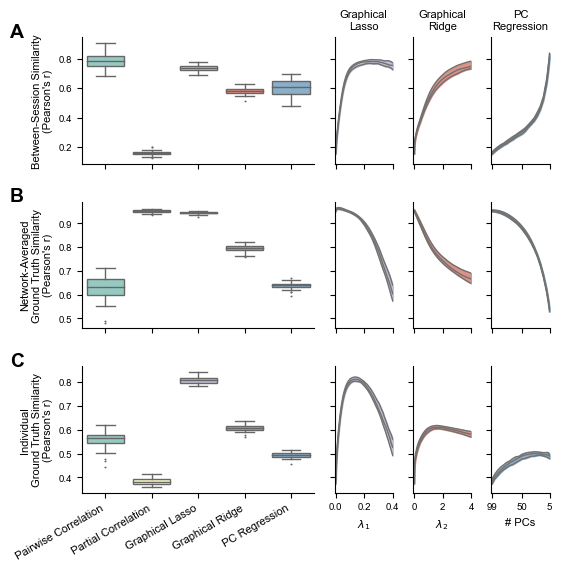

In [10]:
fig,axs = plt.subplots(3,4,figsize=(5.5,5.625),sharex='col',sharey='row',gridspec_kw={'hspace':.3,'wspace':.2,'width_ratios':[4,1,1,1]})
fig.subplots_adjust(left=.14,right=0.99,top=.94,bottom=.13)

# Colors for graph lasso, graph ridge, and pc regress param plots
colors_ = [[.753,.745,.835],[.867,.573,.529],[.573,.682,.776]]
grey = [.439,.443,.439]

methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']

# Loop through metrics (rows of panels)
for n in range(3):
    if n==0: 
        boxData = sesSimDF
        paramData = sesSimByParam
    elif n==1:
        boxData = gtSimAvgDF
        paramData = gtSimAvgByParam
    elif n==2:
        boxData = gtSimDF
        paramData = gtSimByParam

    # Make boxplots
    sns.boxplot(x='Method',y="Data",data=boxData,palette="Set3",ax=axs[n,0],fliersize=.5,linewidth=1)

    # Make hyperparameter line plots (median, 25th percentile, and 75th percentile, like elongated box plot over range of params)
    for m,method in enumerate(['graphicalLasso','graphicalRidge','pcRegression']):
        med = np.nanmedian(paramData[method],axis=0)
        pct25 = np.nanpercentile(paramData[method],25,axis=0)
        pct75 = np.nanpercentile(paramData[method],75,axis=0)
        axs[n,m+1].fill_between(paramsFull[method],pct25,pct75,color=colors_[m],alpha=1)
        axs[n,m+1].plot(paramsFull[method],med,color=grey,linewidth=1)
        axs[n,m+1].plot(paramsFull[method],pct25,color=grey,linewidth=1)
        axs[n,m+1].plot(paramsFull[method],pct75,color=grey,linewidth=1)
        
        #ylims = axs[n,0].get_ylim()
        #axs[n,m+1].set_ylim(ylims)

# X-axis method labels
axs[2,0].set_xticklabels(methodsPrintedLabels, rotation=30, size=8, ha='right',ma='right',rotation_mode='default')
for a in range(3):
    axs[a,0].set_xlabel('')    

# X-axis hyperparams labels
axs[2,1].set_xlim(-.008,.4)
axs[2,2].set_xlim(-.08,4)
axs[2,3].set_xlim(100,5)

axs[2,1].set_xticks([0,.2,.4])
axs[2,2].set_xticks([0,2,4])
axs[2,3].set_xticks([99,50,5])

axs[2,1].set_xlabel('$\lambda_1$',size=8)
axs[2,2].set_xlabel('$\lambda_2$',size=8)
axs[2,3].set_xlabel('# PCs',size=8)

# Y-axis labels
axs[0,0].set_ylabel("Between-Session Similarity\n(Pearson's r)",size=8)
axs[1,0].set_ylabel("Network-Averaged\nGround Truth Similarity\n(Pearson's r)",size=8)
axs[2,0].set_ylabel("Individual\nGround Truth Similarity\n(Pearson's r)",size=8)


# Set right-panel titles
axs[0,1].set_title('Graphical\nLasso',fontsize=8)
axs[0,2].set_title('Graphical\nRidge',fontsize=8)
axs[0,3].set_title('PC\nRegression',fontsize=8)

# Remove borders   
for a1 in range(3):
    for a2 in range(4):
        axs[a1,a2].spines.right.set_visible(False)
        axs[a1,a2].spines.top.set_visible(False)

# Add figure lettering
for m,letter in enumerate(['A','B','C']):
    axs[m,0].text(-2.05,axs[m,0].get_ylim()[1],letter,fontsize=14,ha='left',weight='bold')

if (k==4) and (boldConv==False):
    figFilename = f'{figDir}/figure6.pdf'
elif (k==8) and (boldConv==False):
    figFilename = f'{figDir}/figureS_lessSparseSims.pdf'
elif (k==4) and (boldConv==True):
    figFilename = f'{figDir}/figureS_boldConvSims.pdf'

fig.savefig(figFilename,dpi=600,transparent=True)


# Noise and TRs Analysis

## Load Data

In [ ]:
methodsList = ['pairwiseCorr','partialCorr','graphicalLasso','graphicalRidge','pcRegression']

ses = 0

gtFile = f'{path}/groundTruth.h5'
with h5py.File(gtFile,'r') as h5file:
    W = h5file['W'][:]
    Wsym = h5file['Wsym'][:]
    
FC = {}
bestParam = {}
for method in methodsList:
    print(method)
    connFileFinal = f'{path}/{method}.h5'
    FC[method] = np.full((nNodes,nNodes,nSims,len(noiseLevelsList),len(nTRsList)),np.nan)
    bestParam[method] = np.full((len(nTRsList),len(noiseLevelsList),nSims),np.nan)

    with h5py.File(connFileFinal,'r') as h5File:
        for t,nTRs_ in enumerate(nTRsList):
            for no,noiseLevel_ in enumerate(noiseLevelsList):
                #print(ntrs,noiseLevel)
                FC[method][:,:,:,no,t] = h5File[f'ses-{ses}/noiseLevel-{noiseLevel_}/nTRs-{nTRs_}/FC'][:]
                if not ((method == 'pairwiseCorr') or (method == 'partialCorr')):
                    bestParam[method][t,no,:] = h5File[f'ses-{ses}/noiseLevel-{noiseLevel_}/nTRs-{nTRs_}/bestParams'][:]
            

## Calculate Metrics

In [ ]:
from metrics.matrixSimilarity import matrixSimilarity

# Calculate bwt-ses similarity and individual and ses-averaged ground truth similarity
gtSimDF = pd.DataFrame(data={'Method':[],'Data':[],'Number of Timepoints':[],'Noise Level':[]})
gtSim = {}

for m,method in enumerate(methodsList):
    print(method)
    gtSim[method] = np.full((len(nTRsList),len(noiseLevelsList),nSims),np.nan)
        
    for t,nTRs_ in enumerate(nTRsList):
        for no,noiseLevel_ in enumerate(noiseLevelsList):
            tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
            if (method == 'partialCorr') and (nTRs_ < 100):
                tmpDF['Data'] = np.full((nSims),np.nan)
            else:
                tmpDF['Data'] = matrixSimilarity(FC[method][:,:,:,no,t],Wsym)
            tmpDF['Method'] = method
            tmpDF['Number of Timepoints'] = nTRs_
            tmpDF['Noise Level'] = noiseLevel_
            gtSimDF = pd.concat([gtSimDF,tmpDF])
    
            gtSim[method][t,no,:] = tmpDF['Data'].values
    
gtSimDF.reset_index(inplace=True)

In [ ]:
methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']
colNames = [(' ','row'),(' ','Methods'),(' ',"Noise Level"),("Number of Timepoints","50"),("Number of Timepoints","100"),("Number of Timepoints","200"),("Number of Timepoints","300"),("Number of Timepoints","400"),("Number of Timepoints","500"),("Number of Timepoints","1000"),("Number of Timepoints","10000")]

tableFilename = f'{figDir}/table3.tsv'
    
if os.path.exists(tableFilename):
    tableDF = pd.read_csv(tableFilename,sep='\t',index_col=0,header=[0,1])
else:
    tableDF = pd.DataFrame(columns=pd.MultiIndex.from_tuples(colNames, names=["line1", "line2"]))
    
i = 1
row = 1
for m1,method1 in enumerate(methodsList):
    for m2,method2 in enumerate(methodsList):
        if m2 <= m1:
            continue
        tableDF.loc[i,(' ','row')] = int(row)
        tableDF.loc[i,(' ','Methods')] = f'{methodsPrintedLabels[m1]} vs. {methodsPrintedLabels[m2]}'
        tableDF.loc[i+1,(' ','row')] = ' '
        tableDF.loc[i+1,(' ','Methods')] = ' '
        tableDF.loc[i+2,(' ','row')] = ' '
        tableDF.loc[i+2,(' ','Methods')] = ' '
        
        for no,noiseLevel_ in enumerate(noiseLevelsList):
            tableDF.loc[i,(" ","Noise Level")] = noiseLevel
            for t,nTRs_ in enumerate(nTRsList):
                diff = np.mean(gtSimDF.loc[(gtSimDF['Method']==method1)&(gtSimDF['Noise Level']==noiseLevel_)&(gtSimDF['Number of Timepoints']==nTRs_),'Data'].values-gtSimDF.loc[(gtSimDF['Method']==method2)&(gtSimDF['Noise Level']==noiseLevel_)&(gtSimDF['Number of Timepoints']==nTRs_),'Data'].values)
                [t,p] = stats.ttest_rel(gtSimDF.loc[(gtSimDF['Method']==method1)&(gtSimDF['Noise Level']==noiseLevel_)&(gtSimDF['Number of Timepoints']==nTRs_),'Data'].values,gtSimDF.loc[(gtSimDF['Method']==method2)&(gtSimDF['Noise Level']==noiseLevel_)&(gtSimDF['Number of Timepoints']==nTRs_),'Data'].values)
                if np.isnan(diff):
                    tableStr = f'mean ∆r = NaN'
                else:
                    tableStr = f'mean ∆r = {diff:.3f}, T={formatTStat(t)}, p{formatPVal(p,noSpace=True)}'
                tableDF.loc[i,("Number of Timepoints",str(nTRs_))] = tableStr
            i+=1
        row+=1
            
print(tableDF)
tableDF.to_csv(tableFilename,sep='\t')


# Plot Results

In [ ]:
palette = np.array(sns.color_palette("Set3"))
cols = [palette[2],palette[3],palette[4],palette[5]]

fig,axs = plt.subplots(1,3,figsize=(6.5,1.5),sharex='col',gridspec_kw={'wspace':.75,'width_ratios':[1,1,1]})
fig.subplots_adjust(left=.13,right=0.87,top=.87,bottom=.4)

offset = np.array([-.15,0,.15])*(nTRsList[1]-nTRsList[0])

nTRsListTmp = nTRsList.copy()
nTRsListTmp[-2] = 625
nTRsListTmp[-1] = 750

for m,method in enumerate(['graphicalLasso','graphicalRidge','pcRegression']): 
    for no,noiseLevel_ in enumerate(noiseLevelsList):  
        col = (cols[m]*(1-no*.3) + no*.3)
        axs[m].plot(nTRsList[:-2]+offset[no],np.mean(bestParam[method][:-2,no,:],axis=1),color=col)
        
    h = [0,0,0]
    for no,noiseLevel_ in enumerate(noiseLevelsList):
        col = (cols[m]*(1-no*.3) + no*.3)
        for t,nTRs_ in enumerate(nTRsListTmp):
            sd = np.std(bestParam[method][t,no,:])
            axs[m].plot([nTRs_+offset[no],nTRs_+offset[no]],[np.mean(bestParam[method][t,no,:])-sd,np.mean(bestParam[method][t,no,:])+sd],color=col**3,linewidth=.75)
        h[no] = axs[m].scatter(nTRsListTmp+offset[no],np.mean(bestParam[method][:,no,:],axis=1),3,marker='o',color=col**3,zorder=2)
        
    if m==2:
        axs[m].legend(h,['0.25','0.50','1.00'],title='Noise\nLevels',loc=[1.33,-.7],fontsize=7,handletextpad=0,alignment='left',frameon=True,title_fontsize=8)
        
    if method == 'PC Regress':
        axs[m].set_ylim([99,0])
    else:
        axs[m].set_ylim([0,axs[m].get_ylim()[1]])
    ylims = axs[m].get_ylim()
    xline1 = (nTRsListTmp[-2]-nTRsListTmp[-3])/2 + nTRsListTmp[-3]
    axs[m].plot([xline1,xline1],ylims,':',color=[.8,.8,.8])
    xline2 = (nTRsListTmp[-1]-nTRsListTmp[-2])/2 + nTRsListTmp[-2]
    axs[m].plot([xline2,xline2],ylims,':',color=[.8,.8,.8])
    axs[m].set_ylim(ylims)
    
    # X-axis labels
    axs[m].set_xticks([40,100,200,300,400,500,625,750])
    axs[m].set_xticklabels(['50','100','200','300','400','500','1000','10000'], rotation=60, ha='right',va='center',rotation_mode='anchor')
    axs[m].set_xlabel('Timepoints',size=8)
    axs[m].set_xlim(20,770)

# Y-axis labels
axs[0].set_ylabel('Optimal $\lambda_1$',size=8)
axs[1].set_ylabel('Optimal $\lambda_2$',size=8)
axs[2].set_ylabel('Optimal # PCs',size=8)

# Set titles
axs[0].set_title('Graphical Lasso',fontsize=10)
axs[1].set_title('Graphical Ridge',fontsize=10)
axs[2].set_title('PC Regression',fontsize=10)

# Remove borders   
for m in range(3):
    axs[m].spines.right.set_visible(False)
    axs[m].spines.top.set_visible(False)

# Add figure lettering
for m,letter in enumerate(['A']):
    axs[0].text(-560,axs[0].get_ylim()[1],letter,fontsize=14,ha='left',weight='bold')

fig.savefig(f'{figDir}/fig7-0.pdf',dpi=600,transparent=True)


In [ ]:
pvals = np.zeros((6))

j = 0
for method in ['graphicalLasso','graphicalRidge','pcRegression']:    
    paramVec = np.zeros((len(nTRsList)*len(noiseLevelsList),1))
    noiseVec = np.zeros((len(nTRsList)*len(noiseLevelsList),1))
    timeVec = np.zeros((len(nTRsList)*len(noiseLevelsList),1))
    i = 0
    for t,nTRs_ in enumerate(nTRsList):
        for no,noiseLevel_ in enumerate(noiseLevelsList):
            paramTmp = bestParam[method][t,no,:].flatten()
            paramVec[i] = np.mean(paramTmp)
            noiseVec[i] = noiseLevel_
            timeVec[i] = nTRs_
            i += 1
            
    print(method)
    print(f'Optimal hyperparam vs number TRs: {stats.spearmanr(paramVec,timeVec)}')
    [r,pvals[j]] = stats.spearmanr(paramVec,timeVec)
    j += 1
    print(f'Optimal hyperparam vs noise level: {stats.spearmanr(paramVec,noiseVec)}')
    [r,pvals[j]] = stats.spearmanr(paramVec,noiseVec)
    j += 1
    print()


In [ ]:
cols = np.array([palette[0],palette[1]*.9,palette[2],palette[3],palette[4]])

fig,axs = plt.subplots(1,5,figsize=(6.5,2.75),sharex='col',sharey='row',gridspec_kw={'wspace':.15,'width_ratios':[1,1,1,1,1]})
fig.subplots_adjust(left=.082,right=.995,top=.85,bottom=.22)

offset = np.array([-.15,0,.15])*(nTRsList[1]-nTRsList[0])

for m,method in enumerate(methodsList): 
    for no,noiseLevel_ in enumerate(noiseLevelsList):  
        col = (cols[m]*(1-no*.3) + no*.3)
        axs[m].plot(nTRsList[:-2]+offset[no],np.mean(gtSim[method][:-2,no,:],axis=1),color=col)
        
    h = [0,0,0]
    for no,noiseLevel_ in enumerate(noiseLevelsList):
        col = (cols[m]*(1-no*.3) + no*.3)
        for t,nTRs_ in enumerate(nTRsListTmp):
            sd = np.std(gtSim[method][t,no,:])
            axs[m].plot([nTRs_+offset[no],nTRs_+offset[no]],[np.mean(gtSim[method][t,no,:])-sd,np.mean(gtSim[method][t,no,:])+sd],color=col**3,linewidth=.75)
        
        h[no] = axs[m].scatter(nTRsListTmp+offset[no],np.mean(gtSim[method][:,no,:],axis=1),3,marker='o',color=col**3,zorder=2)
            
    # X-axis labels
    axs[m].set_xticks([40,100,200,300,400,500,625,750])
    axs[m].set_xticklabels(['50','100','200','300','400','500','1000','10000'], rotation=60, ha='right',va='center',rotation_mode='anchor')
    axs[m].set_xlabel('Timepoints',size=8)
    axs[m].set_xlim(20,770)

ylims = [0,1]
xline1 = (nTRsListTmp[-2]-nTRsListTmp[-3])/2 + nTRsListTmp[-3]
xline2 = (nTRsListTmp[-1]-nTRsListTmp[-2])/2 + nTRsListTmp[-2]
for m,method in enumerate(methodsList):
    axs[m].plot([xline1,xline1],ylims,':',color=[.8,.8,.8])
    axs[m].plot([xline2,xline2],ylims,':',color=[.8,.8,.8])
    axs[m].set_ylim(ylims)    

# Y-axis labels
axs[0].set_ylabel('Ground Truth Similarity (r)\n(Individual FC)',size=8)

# Set titles
axs[0].set_title('Pairwise\nCorrelation',fontsize=10)
axs[1].set_title('Partial\nCorrelation',fontsize=10)
axs[2].set_title('Graphical\nLasso',fontsize=10)
axs[3].set_title('Graphical\nRidge',fontsize=10)
axs[4].set_title('PC\nRegression',fontsize=10)

# Remove borders   
for m in range(5):
    axs[m].spines.right.set_visible(False)
    axs[m].spines.top.set_visible(False)

# Add figure lettering
for m,letter in enumerate(['B']):
    axs[0].text(-350,axs[0].get_ylim()[1]+.1,letter,fontsize=14,ha='left',weight='bold')

fig.savefig(f'{figDir}/fig7-1.pdf',dpi=600,transparent=True)